# Dimuon mass spectrum with RumbleDB on Apache Spark

# Histogram of the Dimuon Mass Spectrum

This implements the dimuon mass spectrum analysis, a "Hello World!" example for data analysis in High Energy Physics. It is intended as a technology demonstrator for the use Apache Spark for High Energy Physics.

The workload and data:
  - The input data is a series of candidate muon events. 
  - The job output is a histogram of the dimuon mass spectrum, where several peaks (resonances) can be identified corresponding to well-know particles (e.g. the Z boson at 91 Gev).
  - The computation is based on https://root.cern.ch/doc/master/df102__NanoAODDimuonAnalysis_8C.html and CERN open data from the CMS collaboration linked there. 
  - See also https://github.com/LucaCanali/Miscellaneous/tree/master/Spark_Physics
  
Author and contact: Luca.Canali@cern.ch  
March, 2022

## Dimuon mass spectrum calculation with Spark DataFrame API

In [5]:
# Download the data (2 GB) if not yet available locally

! wget https://sparkdltrigger.web.cern.ch/sparkdltrigger/Run2012BC_DoubleMuParked_Muons.parquet

--2022-11-25 21:39:04--  https://sparkdltrigger.web.cern.ch/sparkdltrigger/Run2012BC_DoubleMuParked_Muons.parquet
Resolving sparkdltrigger.web.cern.ch (sparkdltrigger.web.cern.ch)... 2001:1458:d00:19::12e, 2001:1458:d00:62::100:2e8, 2001:1458:d00:16::41d, ...
Connecting to sparkdltrigger.web.cern.ch (sparkdltrigger.web.cern.ch)|2001:1458:d00:19::12e|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1971962857 (1.8G)
Saving to: ‘Run2012BC_DoubleMuParked_Muons.parquet’

Run2012BC_DoubleMuP 100%[===================>]   1.84G  36.2MB/s    in 26s     

2022-11-25 21:39:30 (73.4 MB/s) - ‘Run2012BC_DoubleMuParked_Muons.parquet’ saved [1971962857/1971962857]



In [ ]:
# Install or update RumbleDB's Python bindings
! pip install -U rumbledb

In [1]:
# RumbleDB runs on Spark
# Currently to use RumbleDB on a notebook you need to start RumbleDB on Spark from CLI in server mode
# See https://rumble.readthedocs.io/en/latest/HTTPServer/
# Download the RumbleDB jar from https://github.com/RumbleDB/rumble/releases
# Note this was last tested on Spark 3.5.1 using RumbleDB v1.21 "Hawthorn blossom"
# wge https://github.com/RumbleDB/rumble/releases/download/v1.21.0/rumbledb-1.21.0-for-spark-3.5.jar

# Start Spark with RumbleDB running the following command
# note this assumes that you are working in the current directory of the jupyter notebook
# run from the CLI (reccommended) or from this cell

import os
os.system("""
export SPARK_HOME=/home/luca/Spark/spark-3.5.1-bin-hadoop3
$SPARK_HOME/bin/spark-submit --driver-memory 4g --conf spark.log.level=error rumbledb-1.21.0-for-spark-3.5.jar serve -p 8001 &
""")


0

24/04/08 21:46:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Starting Rumble in server mode on port 8001...
Server running. Press Control+C to stop.
RumbleDB is now running as a server and accepts requests.

What to do next?

- You can go to http://localhost:8001/public.html in your browser and type queries there.

- You can use Jupyter notebooks to write queries interactively.
You can download a tutorial notebook from https://github.com/RumbleDB/rumble/blob/master/RumbleSandbox.ipynb (use a raw download) that you can point to http://localhost:8001/jsoniq



In [2]:
# Load the Jupyter notebook extension and configute it

%load_ext rumbledb

# customize the max materialize size
%env RUMBLEDB_SERVER=http://localhost:8001/jsoniq?materialization-cap=31000

env: RUMBLEDB_SERVER=http://localhost:8001/jsoniq?materialization-cap=31000


## Check that RumbleDB works in the notebook

In [3]:
%%jsoniq

1+1

Did you know?  🧑‍🏫
The RumbleDB command line interface was extended with convenient shortcuts. For example:

spark-submit <spark parameters> rumbledb-<version>.jar run query.jq
spark-submit <spark parameters> rumbledb-<version>.jar serve -p 8001
spark-submit <spark parameters> rumbledb-<version>.jar run -q '1+1'
spark-submit <spark parameters> rumbledb-<version>.jar repl -c 10

The list of single-dash shortcuts is documented in our documentation page, accessible from www.rumbledb.org.

Try it out! The old parameters will continue to work, though.


Took: 0.3959486484527588 ms
2


## This prepares the code for RumbleDB

In [4]:
# This assumes that Run2012BC_DoubleMuParked_Muons.parquet is in $PWD
# edit the PATH if needed

data = """
declare function local:histogram($values, $lo, $hi, $num-bins) {
  let $flo := float($lo)
  let $fhi := float($hi)
  let $width := ($fhi - $flo) div float($num-bins)
  let $half-width := $width div 2
  let $offset := $flo mod $half-width

  return
    for $value in $values
    let $truncated-value :=
      if ($value lt $flo) then $flo - $half-width
      else
        if ($value gt $fhi) then $fhi + $half-width
        else $value - $offset
    let $bucket-idx := floor($truncated-value div $width)
    let $center := $bucket-idx * $width + $half-width + $offset

    group by $center
    order by $center
    return {"value": $center, "N_events": count($value)}
};

let $filtered :=
  for $event in parquet-file("Run2012BC_DoubleMuParked_Muons.parquet")
    where $event.nMuon = 2 
          and $event.Muon_charge[[1]] != $event.Muon_charge[[2]]
    let $eta_diff := $event.Muon_eta[[1]] - $event.Muon_eta[[2]]
    let $phi_diff := $event.Muon_phi[[1]] - $event.Muon_phi[[2]]
    let $cosh := (exp($eta_diff) + exp(-$eta_diff)) div 2
    let $invariant-mass :=
      sqrt(2 * $event.Muon_pt[[1]] * $event.Muon_pt[[2]] * ($cosh - cos($phi_diff)))      
  return $invariant-mass

return local:histogram($filtered, 0.25, 300, 30000)
"""

## Run the jsoniq code and collects the results in a histogram

In [5]:
import json
import requests

server = "http://localhost:8001/jsoniq?materialization-cap=31000"

%time histogram = json.loads(requests.post(server, data=data).text)

Did you know?  🧑‍🏫
The RumbleDB command line interface was extended with convenient shortcuts. For example:

spark-submit <spark parameters> rumbledb-<version>.jar run query.jq
spark-submit <spark parameters> rumbledb-<version>.jar serve -p 8001
spark-submit <spark parameters> rumbledb-<version>.jar run -q '1+1'
spark-submit <spark parameters> rumbledb-<version>.jar repl -c 10

The list of single-dash shortcuts is documented in our documentation page, accessible from www.rumbledb.org.

Try it out! The old parameters will continue to work, though.
24/04/08 21:47:04 INFO SparkContext: Running Spark version 3.5.1
24/04/08 21:47:04 INFO SparkContext: OS info Linux, 3.10.0-1160.108.1.el7.x86_64, amd64
24/04/08 21:47:04 INFO SparkContext: Java version 11.0.22
[WARNING] Forcing execution mode of variable lo to local.
[WARNING] Forcing execution mode of variable hi to local.
[WARNING] Forcing execution mode of variable num-bins to local.
[WARNING] Forcing execution mode of variable values to l

CPU times: user 47.8 ms, sys: 10.4 ms, total: 58.3 ms
Wall time: 3min 44s


In [6]:
# Convert the results into a Pandas Dataframe

import pandas as pd

histogram_data_pandas = pd.DataFrame(histogram["values"])

In [7]:
histogram_data_pandas

,value,N_events
0,0.245004,377932
1,0.254996,19679
2,0.264987,19285
3,0.274979,18972
4,0.284971,18543
...,...,...
27364,299.915060,1
27365,299.945035,1
27366,299.965018,1
27367,299.985002,2


/tmp/luca/ipykernel_32605/625685022.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


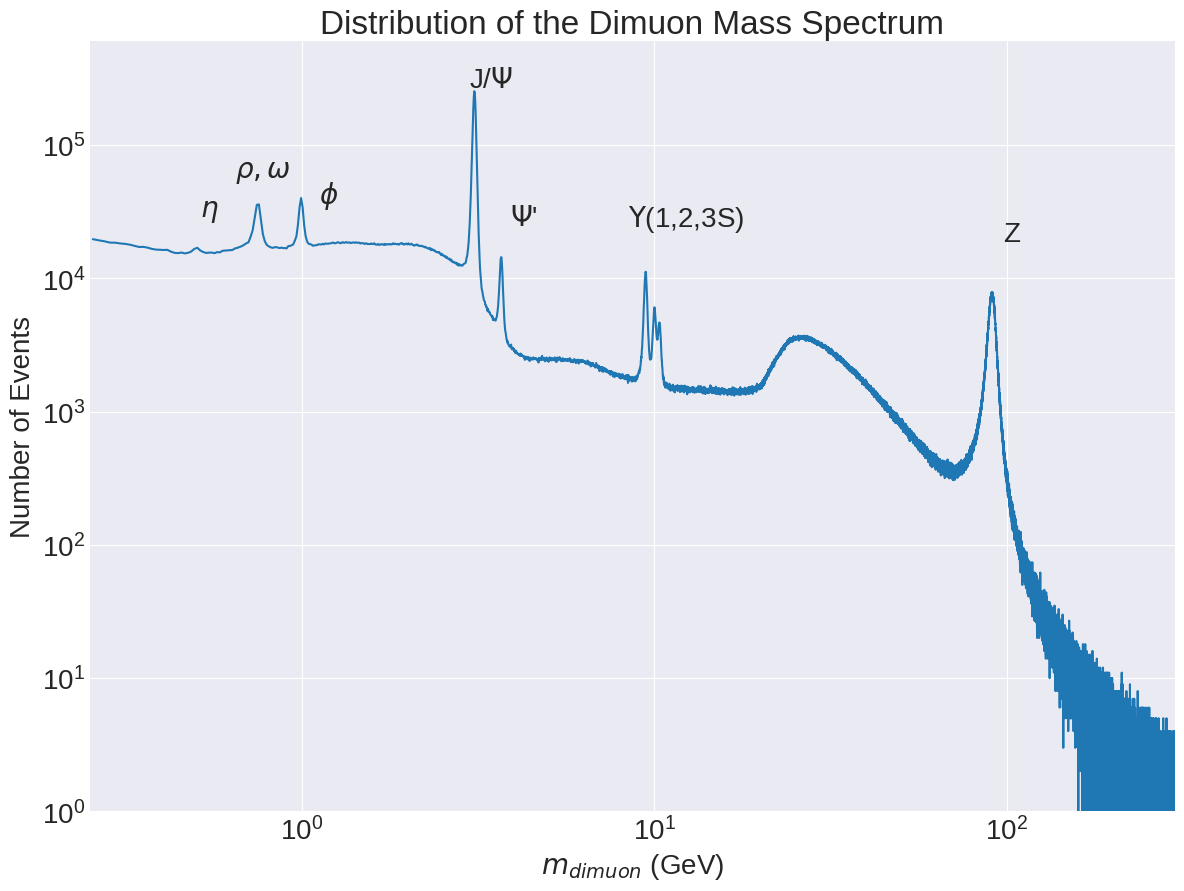

In [8]:
import matplotlib.pyplot as plt 

min_val = 0.25
max_val = 300
num_bins = 30000

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({'font.size': 20, 'figure.figsize': [14,10]})

f, ax = plt.subplots()

# cut the first and last bin
x = histogram_data_pandas.iloc[1:-1]["value"]
y = histogram_data_pandas.iloc[1:-1]["N_events"]

# line plot
ax.plot(x, y, '-')

# the plot is in log-log axis to better show the peaks
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(min_val, max_val)
ax.set_ylim(1, 6e5)

ax.set_xlabel('$m_{dimuon}$ (GeV)')
ax.set_ylabel('Number of Events')
ax.set_title("Distribution of the Dimuon Mass Spectrum")

# Label for the resonances spectrum peaks
txt_opts = {'horizontalalignment': 'center',
            'verticalalignment': 'center',
            'transform': ax.transAxes}

plt.text(0.85, 0.75, 'Z', **txt_opts)
plt.text(0.55, 0.77, r"$\Upsilon$(1,2,3S)", **txt_opts)
plt.text(0.37, 0.95, r"J/$\Psi$", **txt_opts)
plt.text(0.40, 0.77, r"$\Psi$'", **txt_opts)
plt.text(0.22, 0.80, r"$\phi$", **txt_opts)
plt.text(0.16, 0.83, r"$\rho,\omega$", **txt_opts)
plt.text(0.11, 0.78, r"$\eta$", **txt_opts);

plt.show()